## Data Extraction: OPEN WEATHER API ##

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### We define a function to retrieve the name of a city based on its latitude and longitude coordinates using the OpenWeatherMap's Geocoding API. ##

Steps to generate an API key:
1. Visit openweathermap.org.
2. Get signed up and make an account.
3. Verify your email address.
4. Sign in to your account.
5. Find the section that says "API keys."
6. Create an API key and give it a name. This key would further be used to request the dataset.
7. Keep a copy of your API key safe.
8. Review the API instructions to learn how to use it.

In [3]:
def get_city_name(lat, lon, api_key):
    url = f"http://api.openweathermap.org/geo/1.0/reverse?lat={lat}&lon={lon}&appid={api_key}"
    response = requests.get(url)
    data = response.json()
    if data:
        return data[0].get('name', 'Unknown')
    return 'Unknown'

#The API Key is user specific, and can be optained from the above mentioned steps by creating an account
api_key = "63a6f91fefb8e73f227f8b3e384779a3"

#Making a dictionary of locations for the cities we want (latitude, longitude)
locations = [
    {"lat": "51.507351", "lon": "-0.127758"},
    {"lat": "51.454514", "lon": "-2.587910"},
    {"lat": "55.953251", "lon": "-3.188267"},
    {"lat": "33.518589", "lon": "-86.810356"},
    {"lat": "53.400002", "lon": "-2.983333"},
    {"lat": "60.16952", "lon": "24.93545"},
    {"lat": "59.334591", "lon": "18.063240"},
    {"lat": "47.36667", "lon": "8.55"},
    {"lat": "41.902782", "lon": "12.496366"},
    {"lat": "40.416775", "lon": "-3.703790"},
    {"lat": "64.13548", "lon": "-21.89541"}]

#Initializing an empty list  to store weather forecast data for each location.
all_forecasts = []


#Aggregating weather forecast data for all of the locations, structuring them into a DataFrame,and saving that data to a CSV file
#Our Variables of interes are city names, co-ordinates, datetime, Temperature features, Pressure, Humidity and Weather descriptions
for location in locations:
    city_name = get_city_name(location['lat'], location['lon'], api_key)
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={location['lat']}&lon={location['lon']}&appid={api_key}"
    response = requests.get(url)
    data = response.json()

    for entry in data['list']:
        dt_txt = entry['dt_txt']
        main_data = entry['main']
        weather_data = entry['weather'][0]
        all_forecasts.append({
            'city_name': city_name,
            'latitude': location['lat'],
            'longitude': location['lon'],
            'datetime': dt_txt,
            'temp': main_data['temp'],
            'temp_min': main_data['temp_min'],
            'temp_max': main_data['temp_max'],
            'pressure': main_data['pressure'],
            'humidity': main_data['humidity'],
            'weather_main': weather_data['main'],
            'weather_description': weather_data['description']
        })

#Creating DataFrame that will store the extracted data
df = pd.DataFrame(all_forecasts)

#Converting the dataframe to a CSV
csv_file = 'Total_Weather_forecast_with_UKcities_and_EU_cities.csv'
df.to_csv(csv_file, index=False)
print(f"Saved extended forecast data with city names to {csv_file}")


Saved extended forecast data with city names to Total_Weather_forecast_with_UKcities_and_EU_cities.csv


In [4]:
#Loading our generated dataset
data = pd.read_csv("C:/Users/sheth/OneDrive/Desktop/SDPA_task2/Total_Weather_forecast_with_UKcities_and_EU_cities.csv")

# Checking the shape of the dataset
shape = data.shape
print("Shape of the dataset:", shape)

Shape of the dataset: (440, 11)


### Data Cleaning and Exploratory Data Analysis
The next task is to check if the data is clean  by checking the missing values, null values and detecting outliers.
The isnull function is a pandas function to check for missing values in the dataframe.


In [5]:
#Checking for missing values
missing_values = data.isnull().sum()
missing_values

city_name              0
latitude               0
longitude              0
datetime               0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
weather_main           0
weather_description    0
dtype: int64

### Note: Since the data is extracted from an API, the dataset does not have any missing values and null values.

In [6]:
#Taking a peek at the first 5 records of the dataset
data.head()

,city_name,latitude,longitude,datetime,temp,temp_min,temp_max,pressure,humidity,weather_main,weather_description
0,London,51.507351,-0.127758,2024-01-01 18:00:00,281.44,281.44,282.32,999,88,Rain,light rain
1,London,51.507351,-0.127758,2024-01-01 21:00:00,281.91,281.91,282.86,997,89,Rain,moderate rain
2,London,51.507351,-0.127758,2024-01-02 00:00:00,283.45,283.45,284.45,994,90,Rain,moderate rain
3,London,51.507351,-0.127758,2024-01-02 03:00:00,284.12,284.12,284.12,992,81,Clouds,overcast clouds
4,London,51.507351,-0.127758,2024-01-02 06:00:00,284.07,284.07,284.07,992,88,Clouds,overcast clouds


### Checking for Outliers
Data Selection: The defined function checks numerical columns of the dataset.
Identifying Outliers requires three elements for each number column:
Lower quartile (Q1) is 25% of the data.
Upper quartile (Q3) is 75% of the data.

The difference between Q1 and Q3 is the interquartile range (IQR).
Outlier detection: Q1 and Q3 are separated by a threshold. A data point that deviates considerably from these values is a "outlier".
Identifying outliers: The function analyses data in each column and identifies rows that significantly differ from projected values, using Q1, Q3, and IQR.

In [7]:
#Defining the function to detect outliers for each feature using IQR
def detect_outliers_by_feature(df):
    outliers_by_feature = {}

    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # 1st quartile (25%)
        Q1 = df[column].quantile(0.25)
        # 3rd quartile (75%)
        Q3 = df[column].quantile(0.75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Outlier step
        outlier_step = 1.5 * IQR

        # Finding indices of outliers for the column
        outlier_indices = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        
        # Adding to the dictionary
        outliers_by_feature[column] = list(outlier_indices)

    return outliers_by_feature

#Detecting outliers in each feature
outliers_by_feature = detect_outliers_by_feature(data)

#Printing the outliers for each feature
for column, indices in outliers_by_feature.items():
    print(f"Outliers in '{column}': {indices}")

Outliers in 'latitude': []
Outliers in 'longitude': [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
Outliers in 'temp': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 231, 232, 233, 238, 239]
Outliers in 'temp_min': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 231, 232, 233, 238, 239]
Outliers in 'temp_max': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 231, 232, 233, 238, 239]
Outliers in 'pressure': []
Outliers in 'humidity': [128, 129, 145, 152, 153, 399]


### Visualising Outliers using Box Plots
For each column, a separate box plot is created, providing a quick way to assess the central tendency and spread of the data, as well as identifying any extreme values. Box plots are great tools to visualise outliers


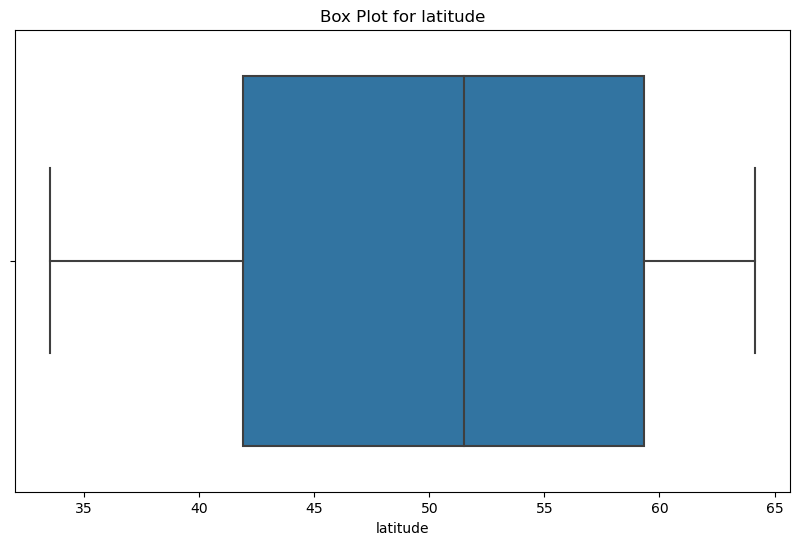

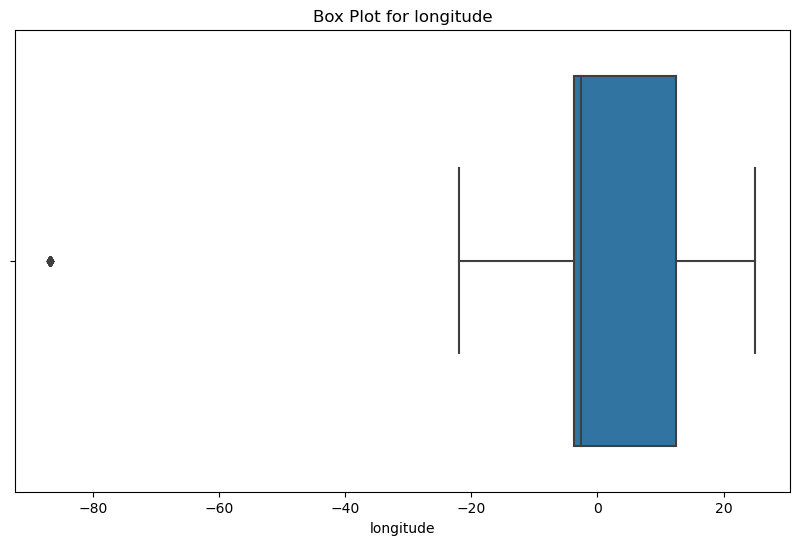

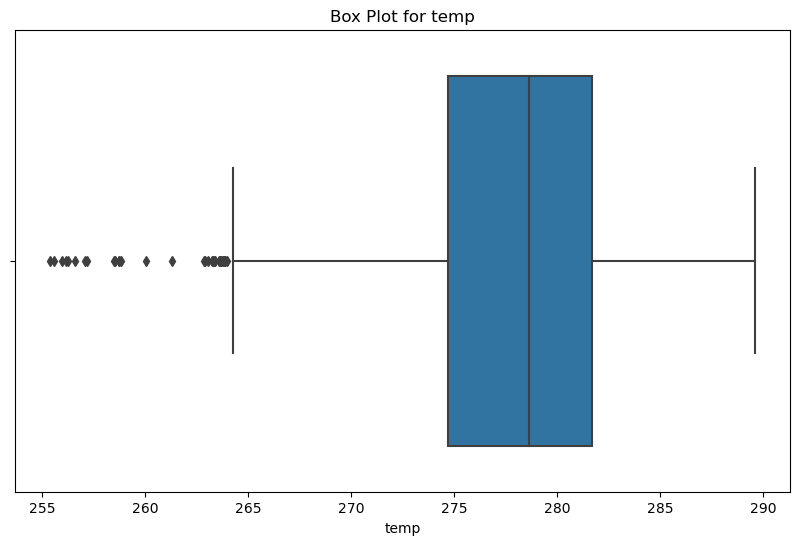

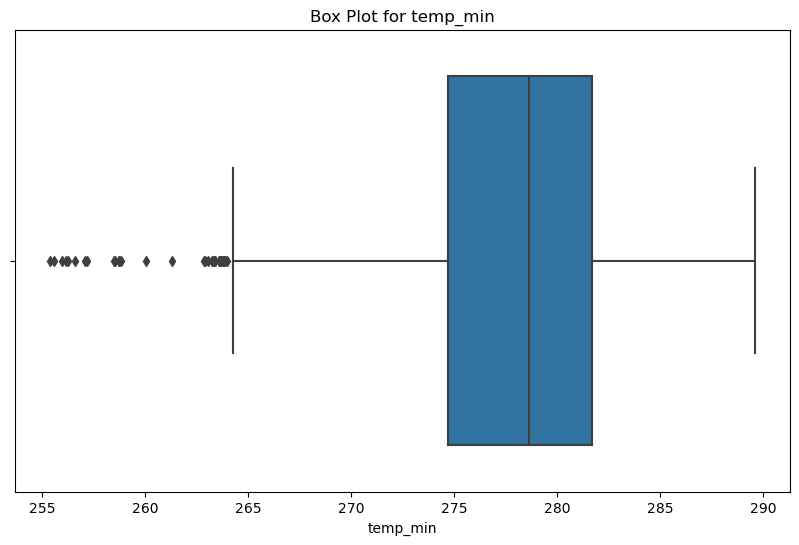

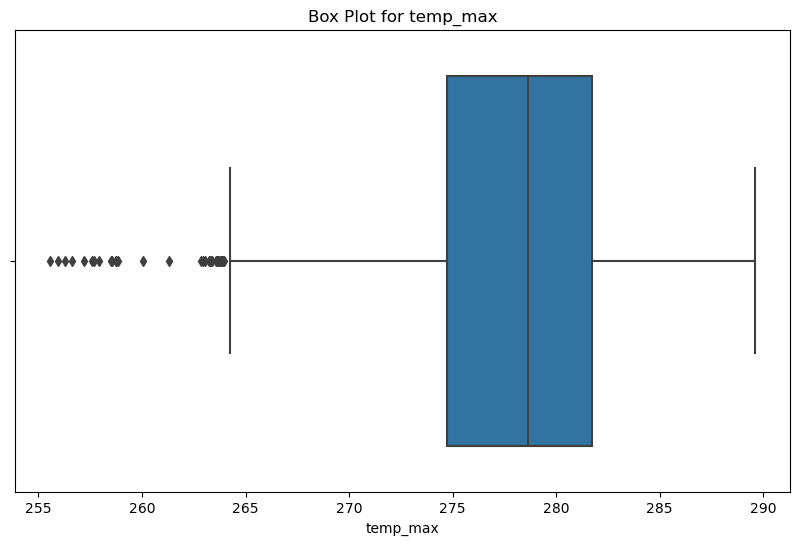

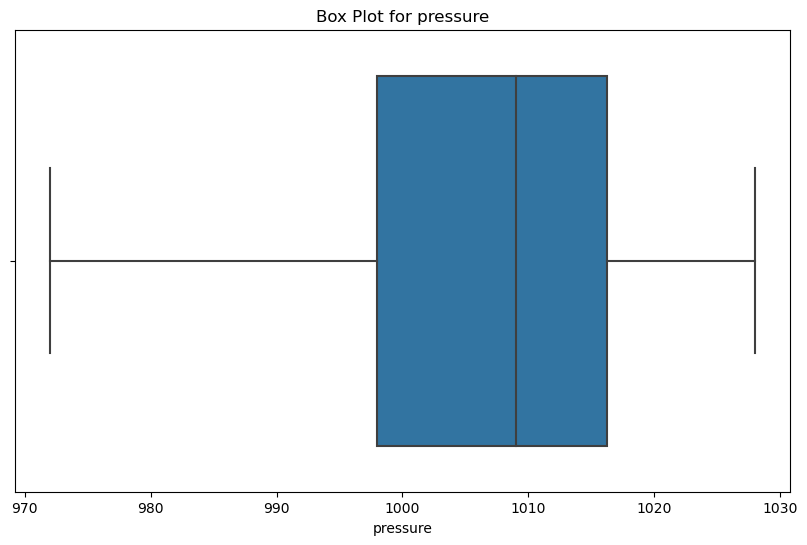

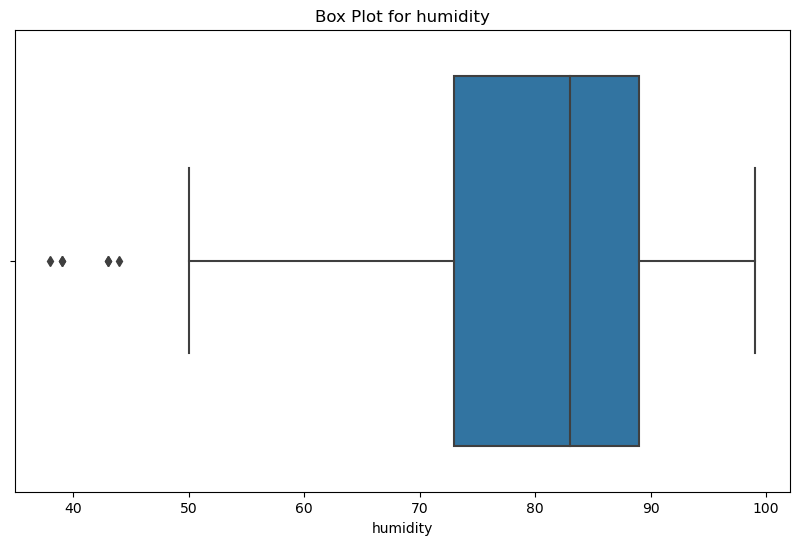

In [8]:
#Selecting only numerical columns for plotting and further analysis
numerical_data = data.select_dtypes(include=['float64', 'int64'])

#To best visualise the outliers, boxplots are plotted for all the numeric columns
for column in numerical_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=numerical_data[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

In [9]:
# Calculating the skewness of each numerical column in the dataset to check weather the data is left or right skewed
skewness = data.select_dtypes(include=['float64', 'int64']).skew()
#To check the distribution of each numeric column, we check the skewness
# Displaying the skewness values
print(skewness)

latitude    -0.407126
longitude   -1.969658
temp        -1.077019
temp_min    -1.070132
temp_max    -1.053707
pressure    -0.581943
humidity    -0.987666
dtype: float64


### Converting the Temperature columns to a standard unit

In [10]:
# Converting Kelvin to Celsius
data['temp'] = data['temp'] - 273.15
data['temp_min'] = data['temp_min'] - 273.15
data['temp_max'] = data['temp_max'] - 273.15

In [11]:
#Checking how the dtaset looks after conversion
data.head()

,city_name,latitude,longitude,datetime,temp,temp_min,temp_max,pressure,humidity,weather_main,weather_description
0,London,51.507351,-0.127758,2024-01-01 18:00:00,8.29,8.29,9.17,999,88,Rain,light rain
1,London,51.507351,-0.127758,2024-01-01 21:00:00,8.76,8.76,9.71,997,89,Rain,moderate rain
2,London,51.507351,-0.127758,2024-01-02 00:00:00,10.30,10.30,11.30,994,90,Rain,moderate rain
3,London,51.507351,-0.127758,2024-01-02 03:00:00,10.97,10.97,10.97,992,81,Clouds,overcast clouds
4,London,51.507351,-0.127758,2024-01-02 06:00:00,10.92,10.92,10.92,992,88,Clouds,overcast clouds


### For simplification and better decision making lets add a categorical column for all temperature values
Defining a function to categorize temperature column and put all values in one of the following:
1. 'Very Cold' for temperatures less than or equal to -10.
2. 'Cold' for temperatures greater than -10 and less than or equal to 0.
3. 'Cool' for temperatures greater than 0 and less than or equal to 5.
4. 'Mild' for temperatures greater than 5 and less than or equal to 10.
5. 'Warm' for temperatures greater than 10 and less than or equal to 15.
6. 'Very Warm' for temperatures greater than 15.

In [12]:
def categorize_temperature(temp):
    if temp <= -10:
        return 'Very Cold'
    elif temp <= 0:
        return 'Cold'
    elif temp <= 5:
        return 'Cool'
    elif temp <= 10:
        return 'Mild'
    elif temp <= 15:
        return 'Warm'
    else:
        return 'Very Warm'

# Applying the function to the temperature column and check the updated dataset
data['temp_category'] = data['temp'].apply(categorize_temperature)
data.head()

,city_name,latitude,longitude,datetime,temp,temp_min,temp_max,pressure,humidity,weather_main,weather_description,temp_category
0,London,51.507351,-0.127758,2024-01-01 18:00:00,8.29,8.29,9.17,999,88,Rain,light rain,Mild
1,London,51.507351,-0.127758,2024-01-01 21:00:00,8.76,8.76,9.71,997,89,Rain,moderate rain,Mild
2,London,51.507351,-0.127758,2024-01-02 00:00:00,10.30,10.30,11.30,994,90,Rain,moderate rain,Warm
3,London,51.507351,-0.127758,2024-01-02 03:00:00,10.97,10.97,10.97,992,81,Clouds,overcast clouds,Warm
4,London,51.507351,-0.127758,2024-01-02 06:00:00,10.92,10.92,10.92,992,88,Clouds,overcast clouds,Warm


In [13]:
#converting the string column to a standard datetime column 
data['datetime'] = pd.to_datetime(data['datetime'])
data.head()

,city_name,latitude,longitude,datetime,temp,temp_min,temp_max,pressure,humidity,weather_main,weather_description,temp_category
0,London,51.507351,-0.127758,2024-01-01 18:00:00,8.29,8.29,9.17,999,88,Rain,light rain,Mild
1,London,51.507351,-0.127758,2024-01-01 21:00:00,8.76,8.76,9.71,997,89,Rain,moderate rain,Mild
2,London,51.507351,-0.127758,2024-01-02 00:00:00,10.30,10.30,11.30,994,90,Rain,moderate rain,Warm
3,London,51.507351,-0.127758,2024-01-02 03:00:00,10.97,10.97,10.97,992,81,Clouds,overcast clouds,Warm
4,London,51.507351,-0.127758,2024-01-02 06:00:00,10.92,10.92,10.92,992,88,Clouds,overcast clouds,Warm


### Treating the outliers in all the temperature and humidity features using the Capping Method
Capping method is used to treat the outliers as there the data is left skewed. Instead of cutting or getting rid of outliers, capping keeps all the data points by bringing the high values down to a certain level. 

In [14]:
#Calculating the Interquartile Range (IQR) for each temperature column
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

#Determining the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Capping the outliers in 'temp', 'temp_min', 'temp_max' and 'humidity'
capped_columns = ['temp', 'temp_min', 'temp_max','humidity']
for col in capped_columns:
    data[col] = data[col].clip(lower=lower_bound[col], upper=upper_bound[col])
    


In [15]:
data

,city_name,latitude,longitude,datetime,temp,temp_min,temp_max,pressure,humidity,weather_main,weather_description,temp_category
0,London,51.507351,-0.127758,2024-01-01 18:00:00,8.29,8.29,9.17,999,88.0,Rain,light rain,Mild
1,London,51.507351,-0.127758,2024-01-01 21:00:00,8.76,8.76,9.71,997,89.0,Rain,moderate rain,Mild
2,London,51.507351,-0.127758,2024-01-02 00:00:00,10.30,10.30,11.30,994,90.0,Rain,moderate rain,Warm
3,London,51.507351,-0.127758,2024-01-02 03:00:00,10.97,10.97,10.97,992,81.0,Clouds,overcast clouds,Warm
4,London,51.507351,-0.127758,2024-01-02 06:00:00,10.92,10.92,10.92,992,88.0,Clouds,overcast clouds,Warm
...,...,...,...,...,...,...,...,...,...,...,...,...
435,Reykjavik,64.135480,-21.895410,2024-01-06 03:00:00,4.83,4.83,4.83,1010,90.0,Rain,light rain,Cool
436,Reykjavik,64.135480,-21.895410,2024-01-06 06:00:00,4.05,4.05,4.05,1010,91.0,Rain,light rain,Cool
437,Reykjavik,64.135480,-21.895410,2024-01-06 09:00:00,4.10,4.10,4.10,1010,92.0,Rain,light rain,Cool
438,Reykjavik,64.135480,-21.895410,2024-01-06 12:00:00,5.63,5.63,5.63,1009,88.0,Rain,light rain,Mild


### Computing Descriptive Statistics for all numeric columns except the co-ordinates

In [16]:
#Selecting only the numeric columns (excluding 'latitude' and 'longitude')
numeric_columns = data.select_dtypes(include='number').drop(['latitude', 'longitude'], axis=1)

#Calculating various statistics for the selected numeric columns
statistics = numeric_columns.describe()

#Calculating the range (max - min) for each selected numeric column
range_data = numeric_columns.max() - numeric_columns.min()
range_data.name = 'range'

#Appending the range data to the statistics
statistics = statistics.append(range_data)

print(statistics)

             temp    temp_min    temp_max     pressure    humidity
count  440.000000  440.000000  440.000000   440.000000  440.000000
mean     4.120341    4.094773    4.142511  1006.665909   81.045455
std      6.232722    6.229521    6.261954    12.621879   10.570416
min     -8.890000   -8.890000   -8.957500   972.000000   49.000000
25%      1.565000    1.565000    1.565000   998.000000   73.000000
50%      5.490000    5.465000    5.490000  1009.000000   83.000000
75%      8.535000    8.535000    8.580000  1016.250000   89.000000
max     16.430000   16.430000   16.430000  1028.000000   99.000000
range   25.320000   25.320000   25.387500    56.000000   50.000000


C:\Users\sheth\AppData\Local\Temp\ipykernel_37404\2270398486.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics = statistics.append(range_data)


The weather data shows that the climate is cool, with normal temperatures around 4.12°C and big changes between -8.89°C and 16.43°C. The temperature data has a standard deviation of about 6.23°C, which shows a lot of variation. This suggests that the data may cover more than one season or type of weather. The average pressure in the atmosphere is 1006.67 hPa, and it stays mostly the same during different weather conditions.

### Visualising the numeric columns with Histograms

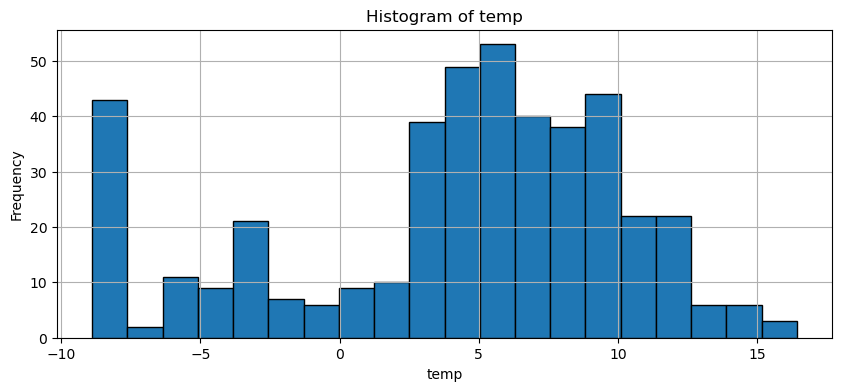

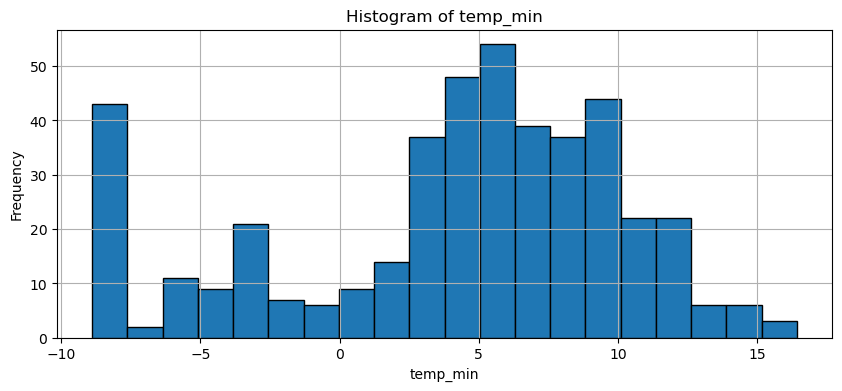

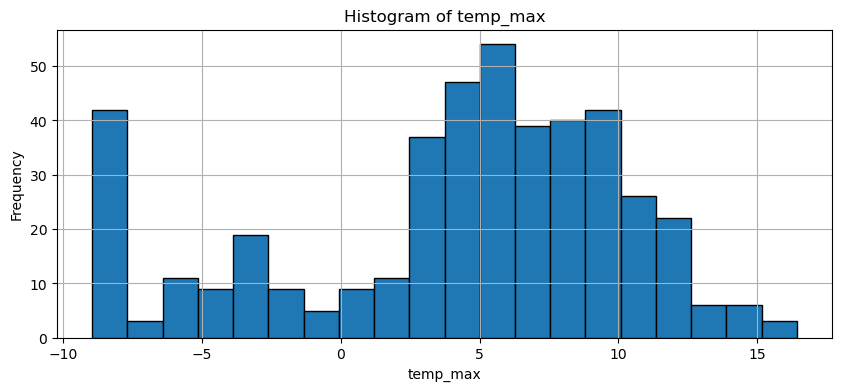

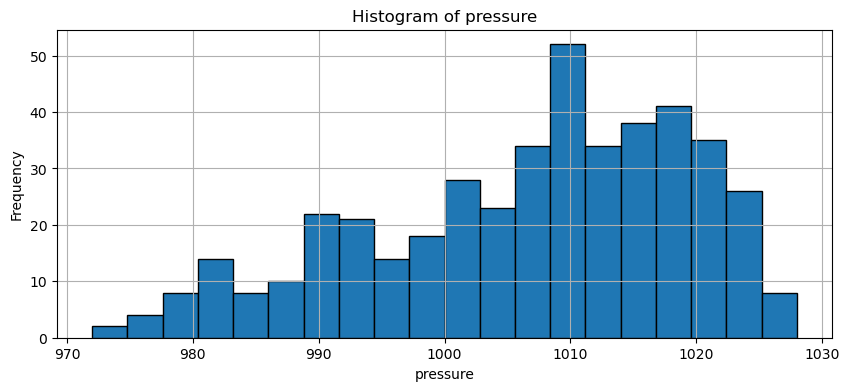

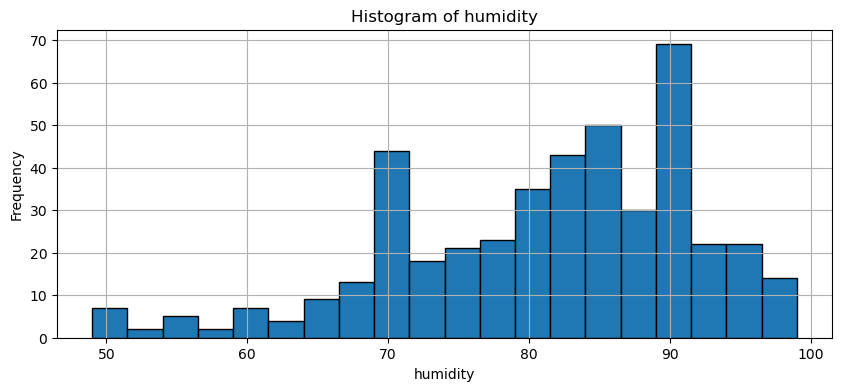

In [17]:
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    plt.hist(numeric_columns[column], bins=20, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Histograms are plotted to explore the distributions across features in the dataset. They are plotted for Temperature, Humidity anf Atmospheric Pressure where we can also visualise the skewness, each feature follows.

### Plotting a Scatterplot for two significant features of the dataset

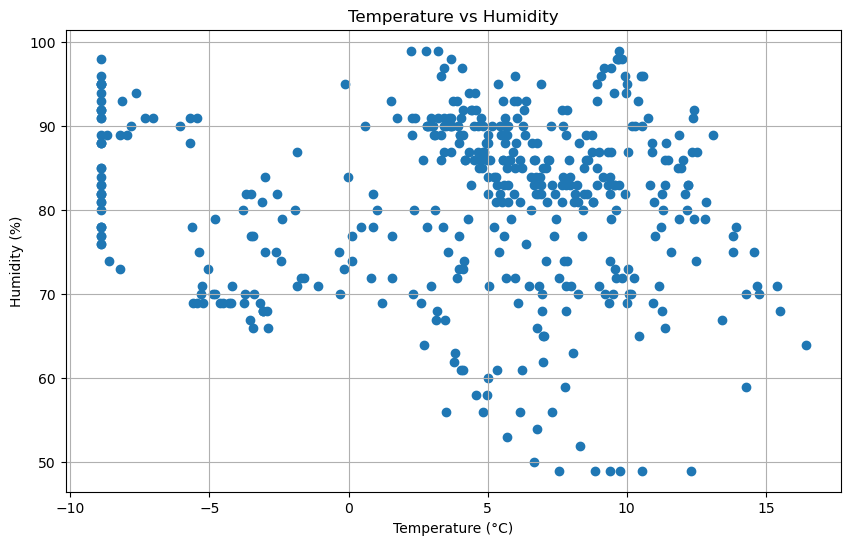

In [18]:
# Scatter plot between temperature and humidity
plt.figure(figsize=(10, 6))
plt.scatter(data['temp'], data['humidity'])
plt.title('Temperature vs Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.grid(True)
plt.show()

The above scatter plot indicates relationship of Temperature and Humidity in the dataset where we see a significant cluster in humidity ranges 80%-90% showing dominance of humid cities across the dataset. Also, as and when the temperature increases, there is a fall in humidity levels across cities.

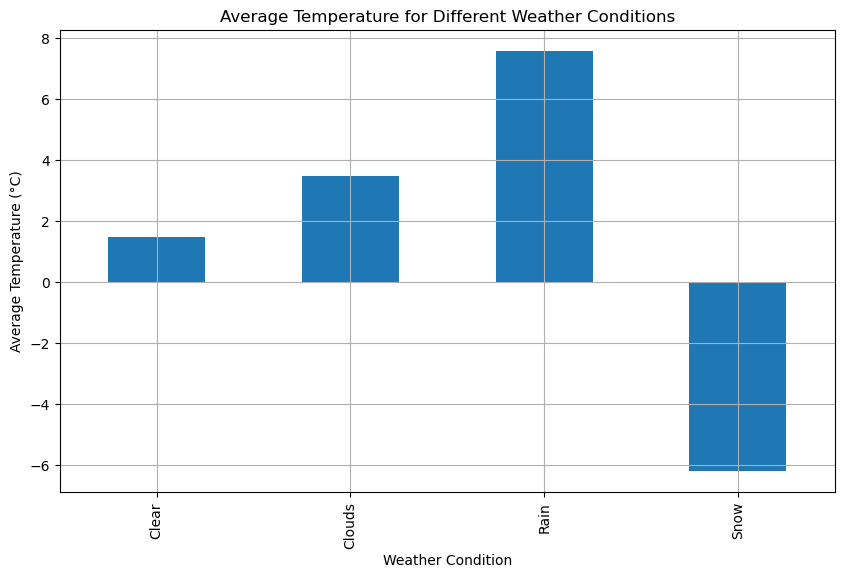

In [19]:
#Plotting average temperature for different weather conditions
avg_temp_weather = data.groupby('weather_main')['temp'].mean()

#Bar chart for average temperature per weather condition
avg_temp_weather.plot(kind='bar', figsize=(10, 6))
plt.title('Average Temperature for Different Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

The above plot is quite self-explanatory, indicating that the average rainy and snowy weather conditions have temperatures 7.6°C and -6.1°C respectively. Clear and clowdy conditions on the other hand range at 1.5°C and 3.5°C respectively. Checking the average temperatures with respect to the cities is addressed further.

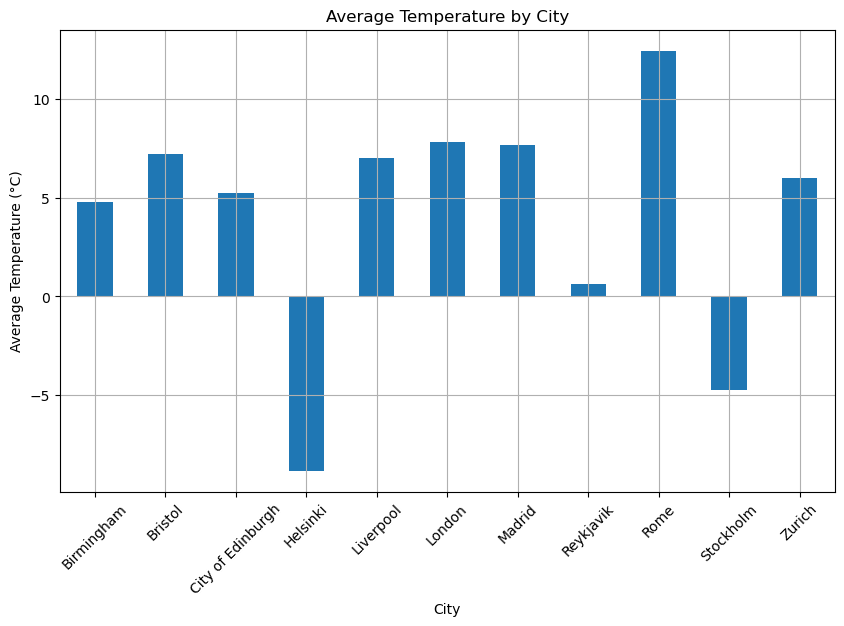

In [20]:
#Plotting average temperature for each city
avg_temp_city = data.groupby('city_name')['temp'].mean()

#Bar chart for average temperature per city
avg_temp_city.plot(kind='bar', figsize=(10, 6))
plt.title('Average Temperature by City')
plt.xlabel('City')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The bar plot shows the highest and lowest average temperature across the dataset that we have extracted, which range from 14°C in Rome to -8°C in Helsinki. Liverpool, Madrid, London and Bristol experience similar average temperatures at approximately 7°C.

### Plotting the weather conditions in each city

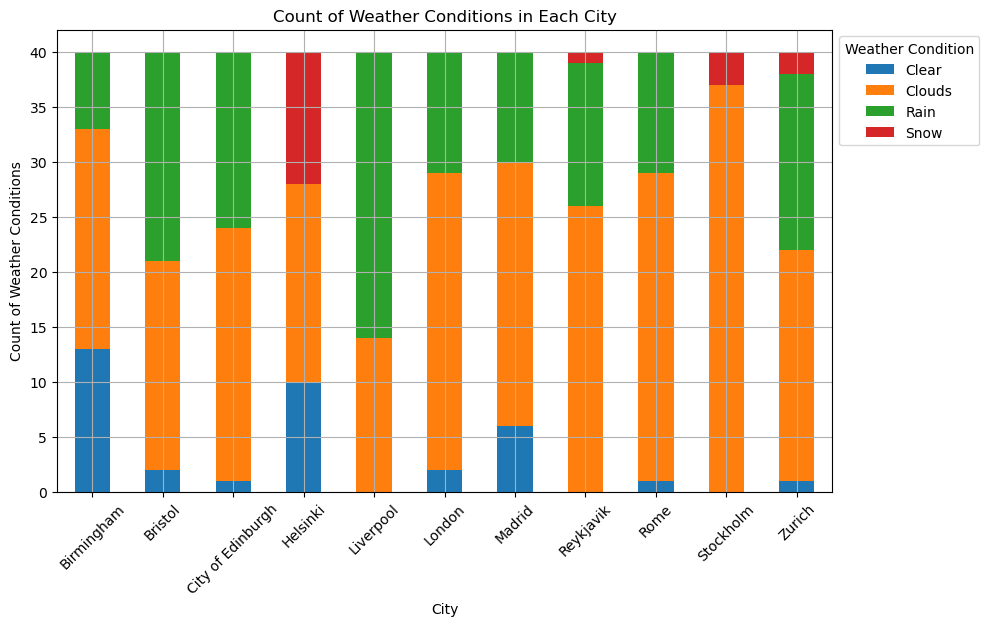

In [22]:
# Count of weather conditions in each city
weather_count_city = data.groupby(['city_name', 'weather_main']).size().unstack()

# Bar chart for count of weather conditions per city
weather_count_city.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Weather Conditions in Each City')
plt.xlabel('City')
plt.ylabel('Count of Weather Conditions')
plt.xticks(rotation=45)
plt.legend(title='Weather Condition', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


The following stacked bar graph indicates cloudy weather conditions dominating in all the cities especially in Stockholm, Rome and London. Subsequently, Rains dominates in Liverpool and snowy conditions are sparse in Reykjavik, Stockholm and Zurich, wheras Helsinki experiences a significant amount of snowy weather conditions.

### Plotting Humidity distribution in different cities

<Figure size 1200x600 with 0 Axes>

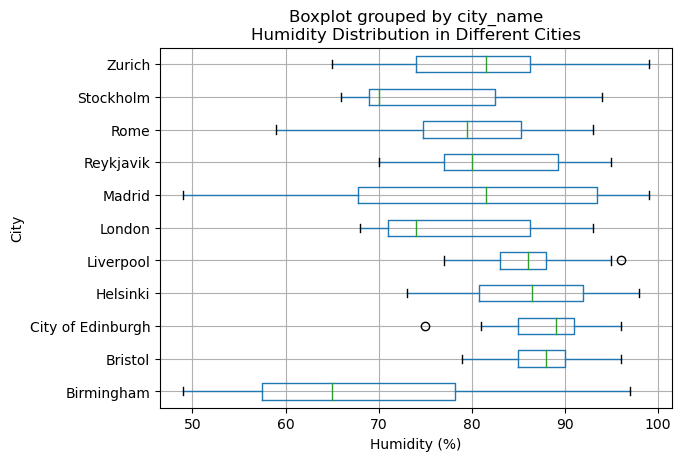

In [23]:
#Boxplots can be used to visualize the distribution of humidity in different cities, highlighting the median,
#quartiles, and outliers.

plt.figure(figsize=(12, 6))
data.boxplot(column='humidity', by='city_name', vert=False)
plt.title('Humidity Distribution in Different Cities')
plt.xlabel('Humidity (%)')
plt.ylabel('City')
plt.grid(True)
plt.show()

Here, we observe that cities, Rome, Reykjavik, and Madrid have similar median humidity levels which ranges around 80%. The whiskers, which represent the range show that Birmingham and Madrid have the widest range of humidity levels as compared to other cities. 

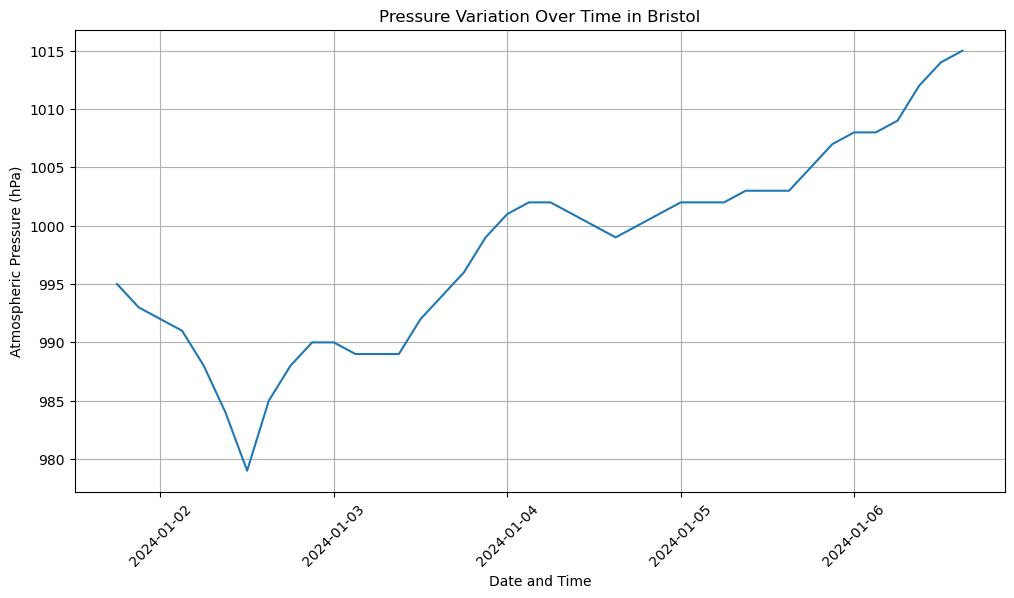

In [25]:
#Plotting a line graph to see how the atmospheric pressure changes over time in any specific city
#Let's choose Bristol as an example.
specific_city = 'Bristol'  
city_data = data[data['city_name'] == specific_city]

plt.figure(figsize=(12, 6))
plt.plot(city_data['datetime'], city_data['pressure'])
plt.title(f'Pressure Variation Over Time in {specific_city}')
plt.xlabel('Date and Time')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In the above plot, we see that is In Bristol on January 2, there was a sharp drop in air pressure that could indicate a storm coming. Further there are changes in the pressure which show unstable weather. After that, from January 3rd to 6th, there is a steady rise in pressure. This could mean, clearer weather that is typical of winter weather changes.


## Asking Questions about the extracted and computed dataset

### Question 1: How do weather conditions correlate with atmospheric pressure and temperature variations across cities?

 To move ahead with the question: 
 We will explores the relationship between weather conditions, atmospheric pressure, and temperature
 Furthermore, we will divide the question into sub-questions:
 
 1.] Correlation Analysis:
 What is the correlation between temperature and atmospheric pressure in different weather conditions?
 How does humidity correlate with temperature in various weather conditions?

 2.] City-wise Analysis:
 Are there significant differences in how these relationships manifest across different cities?
 Can we identify cities with unique weather patterns compared to the general trends?


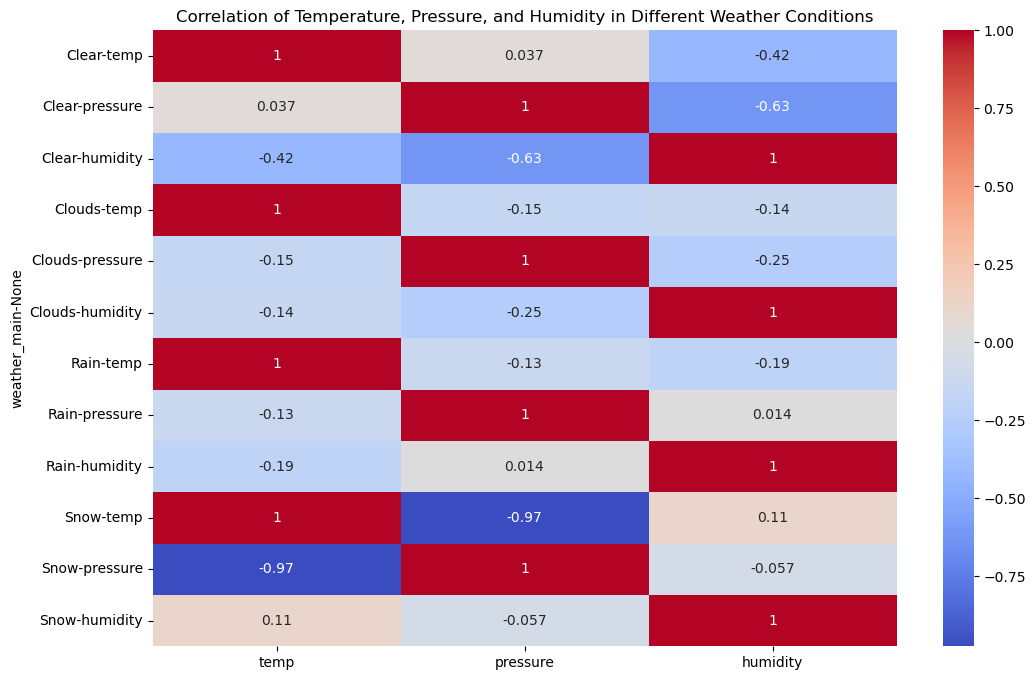

In [26]:
#Subpart1:
'''
To answer these questions, we would perform statistical analyses, including correlation analysis,
to understand the relationships between variables. We would also group the data by weather conditions, seasons, and cities to 
observe variations in these relationships.
We can start by analyzing the correlation between temperature, pressure, and humidity in different weather conditions.
'''

#Analysing the correlation between temperature, pressure, and humidity in different weather conditions.
# Selecting relevant columns for the analysis
temp_pressure_data = data[['temp', 'pressure', 'humidity', 'weather_main']]

# Grouping by weather conditions and calculating correlation
correlation_by_weather = temp_pressure_data.groupby('weather_main').corr()

# Visualizing the correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_by_weather, annot=True, cmap='coolwarm')
plt.title('Correlation of Temperature, Pressure, and Humidity in Different Weather Conditions')
plt.show()



Temperature and atmospheric pressure show a very strong negative correlation of -0.97 in snowy conditions, while in clear, cloudy, and rainy conditions, the correlation is nearly zero and slightly negative. Humidity and temperature have a moderate negative correlation in clear weather of -0.44 and weak negative correlations in cloudy and rainy weather, with a slight positive correlation in snowy conditions of 0.11.



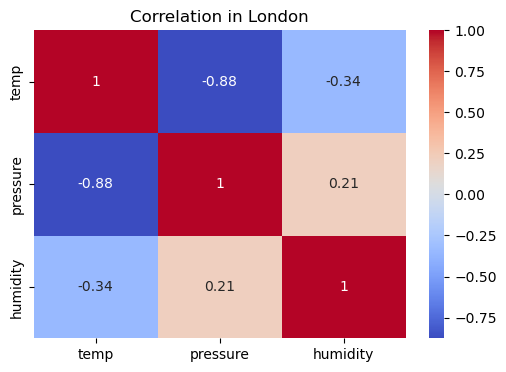

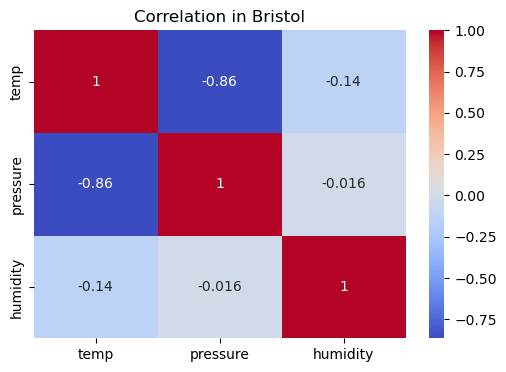

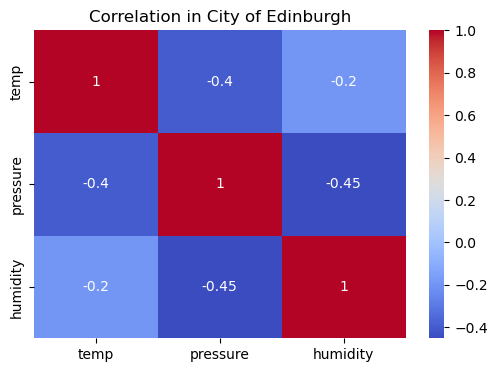

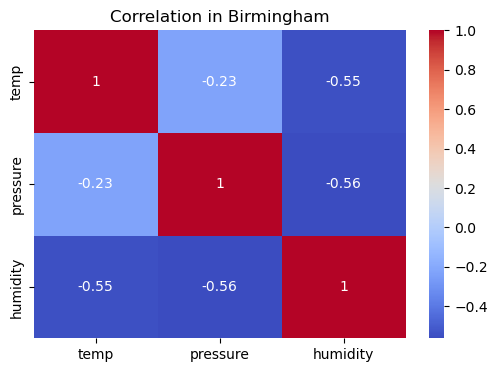

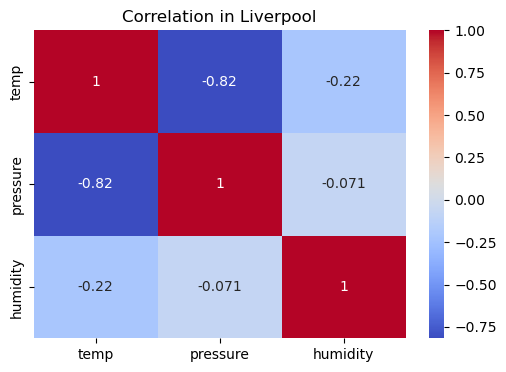

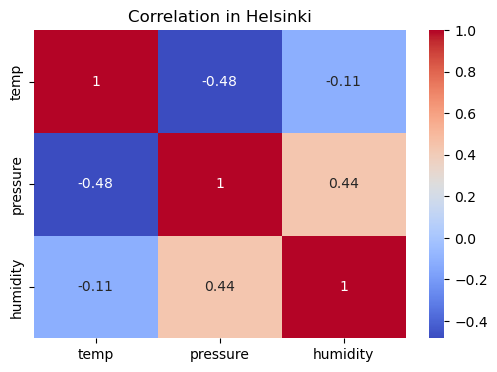

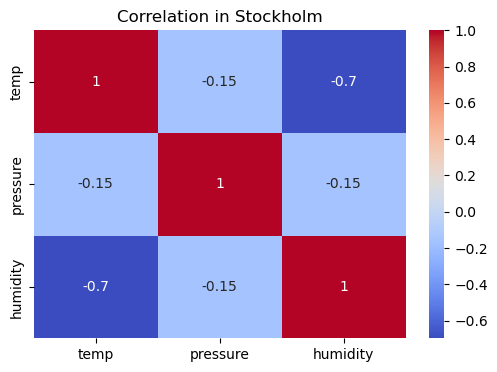

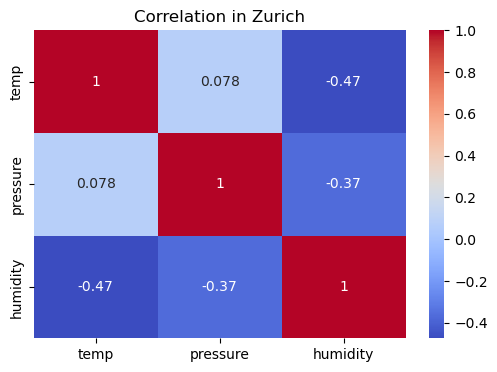

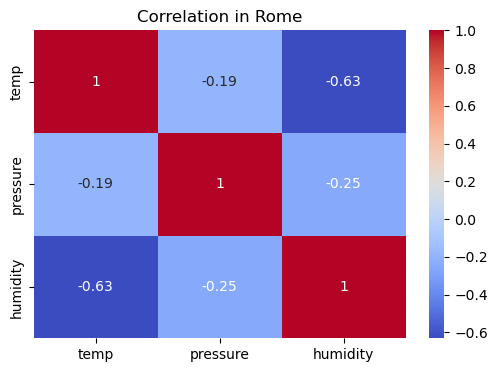

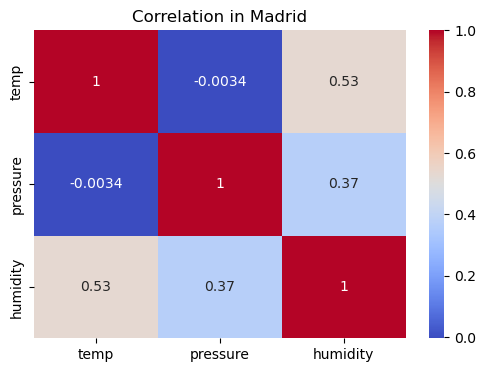

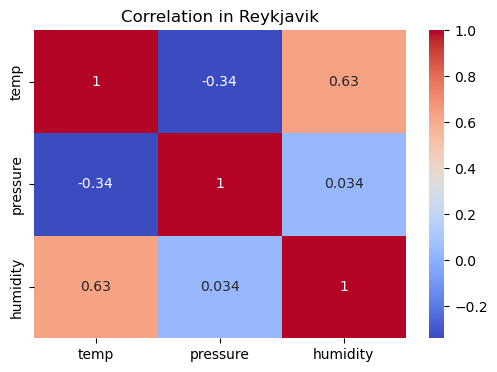

In [27]:
#Subpart2:

#Hereby, we go deeper and calculate correlations for the metrics for individual cities.
#Recalculating the correlations for each city
correlation_by_city = data.groupby('city_name')[['temp', 'pressure', 'humidity']].corr()

#Visualizing with a heatmap for each city
for city in data['city_name'].unique():
    plt.figure(figsize=(6, 4))
    # Extracting the correlation data for the specific city
    city_corr = correlation_by_city.loc[city].dropna(axis=1, how='all').dropna(axis=0, how='all')
    sns.heatmap(city_corr, annot=True, cmap='coolwarm')
    plt.title(f'Correlation in {city}')
    plt.show()


Cities like London and Bristol show a strong negative correlation between temperature and pressure, which is not noticed in cities like Edinburgh and Birmingham, indicating regional differences in how temperature affects atmospheric pressure.

In Helsinki and Reykjavik, there is a positive correlation between humidity and pressure. This is different from other cities, where the relationship is nagative. This indicates that the weather in these places is different from the general trend seen in other cities.

### Question 2: How do temperature extremes vary across cities, and what might this imply for urban living conditions and environmental planning?

The question aims to explore the range and frequency of extreme temperature conditions across different cities and consider potential implications for urban living, health, and planning. We can break it down into several sub-questions:

1.] What are the highest and lowest temperatures recorded in each city? How do these extremes compare across cities?

2.] What is the variability in temperature within each city, and how does this compare across cities? Are there noticeable trends or patterns in temperature changes over time within each city?

3.] Based on the temperature data, which cities might require more robust infrastructure to cope with extreme temperatures? How might the observed temperature patterns influence urban planning, such as heating and cooling needs or public health advisories?

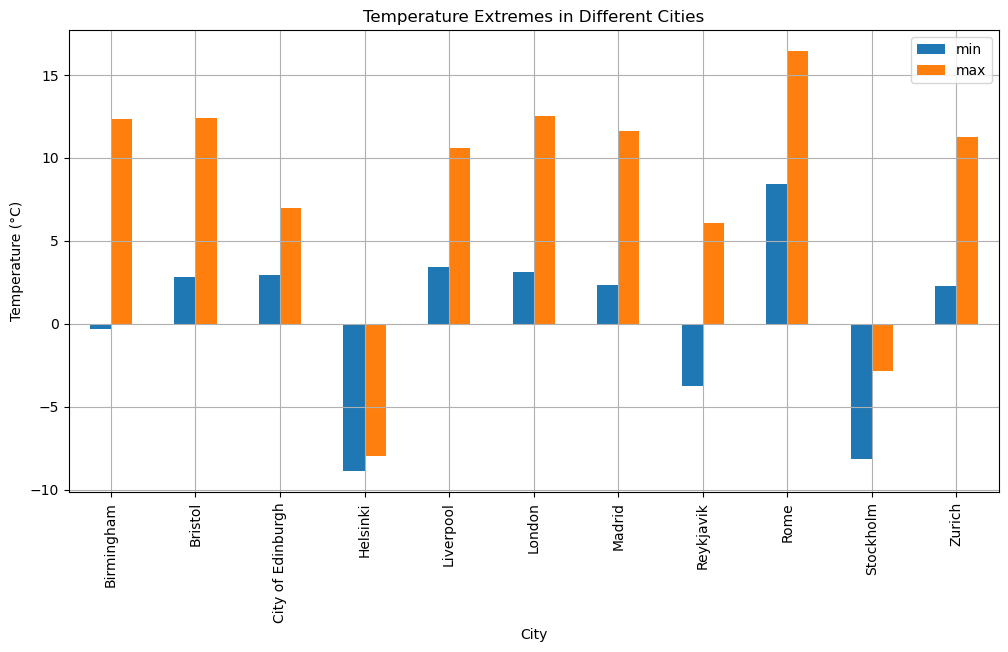

In [28]:
#Subpart1: To calculate the highest and lowest temperatures recorded in each city we will define Temperature Extremes
# Analyzing temperature extremes in each city
temp_extremes = data.groupby('city_name')['temp'].agg(['min', 'max'])

# Plotting the temperature extremes for each city
temp_extremes.plot(kind='bar', figsize=(12, 6))
plt.title('Temperature Extremes in Different Cities')
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


The hottest place on record are in Rome, where it gets up to 16°C. Helsinki has the coldest temperature, with lows of around -9°C. When we look at these extremes side by side, Stockholm and Helsinki have the coolest temperatures ever recorded, while Rome has the warmest.

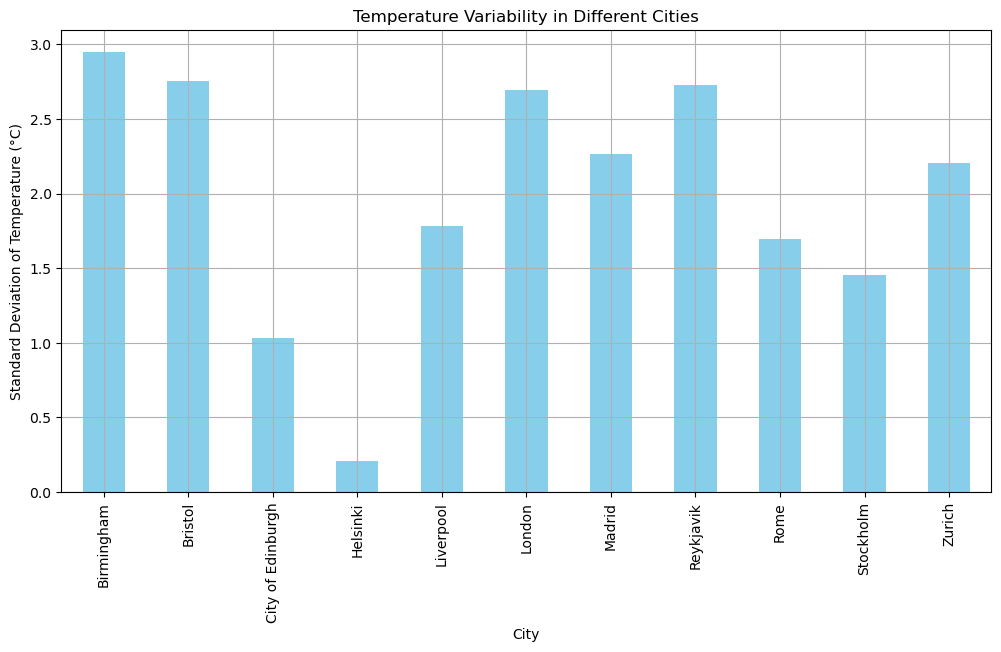

In [29]:
#Subpart2.1: Temperature Variability
#Calculating the standard deviation for temperatures in each city
temp_std_dev = data.groupby('city_name')['temp'].std()

#Plotting the standard deviation for each city
temp_std_dev.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Temperature Variability in Different Cities')
plt.xlabel('City')
plt.ylabel('Standard Deviation of Temperature (°C)')
plt.grid(True)
plt.show()


The standard deviation of temperature across all towns is plotted on the bar chart. Standard deviation shows how the temperature changes in each place. Birmingham has the most changing temperatures, coming close to 2.8°C. The temperature changes the least in Helsinki, which is just under 0.20°C. The temperatures in the cities of Edinburgh and Stockholm are also less likely to change. Edinburgh is about 1°C and Stockholm, about 1.45°C.

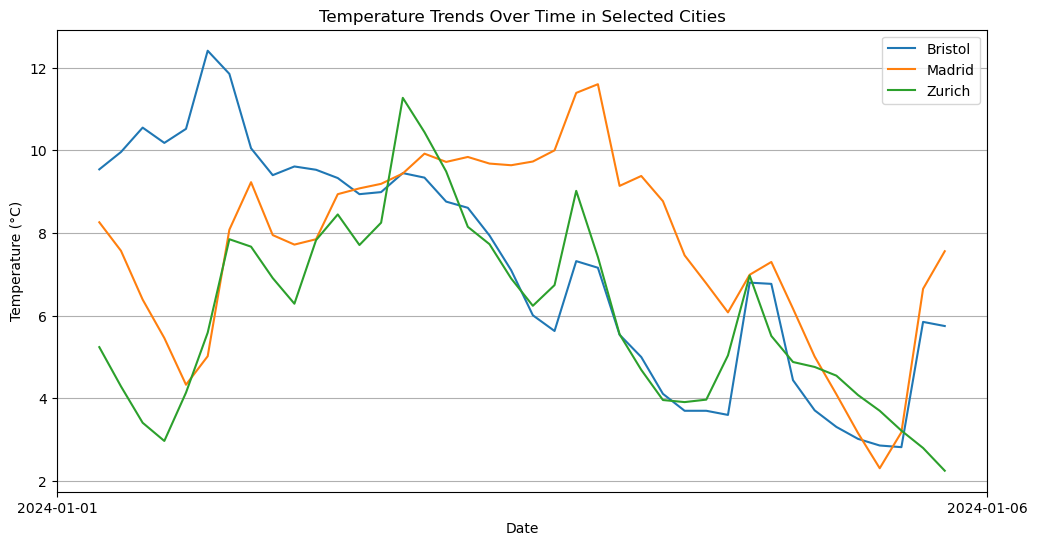

In [30]:
#Subpart2.2: Temperature Trends
import matplotlib.dates as mdates

# Selecting a few cities for trend analysis
selected_cities = ['Bristol', 'Madrid', 'Zurich']  # Replace with actual city names from your dataset

plt.figure(figsize=(12, 6))

# Plotting temperature trends
for city in selected_cities:
    city_data = data[data['city_name'] == city]
    plt.plot(city_data['datetime'], city_data['temp'], label=city)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.title('Temperature Trends Over Time in Selected Cities')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


We observe the following trends in the cities:
Bristol's temperature is gradually dropping down, with a small rise near the end.
The most noticeable changes can be seen in Madrid, where temperatures have changed dramatically over the days that were tracked.
Zurich has a noticeable warming trend in the middle of the time period, but it ends close to where it began, indicating a short period of warming followed by cooling.

In [31]:
#Subpart3: Implications for Urban Environments:

# Combining extremes and variability data
temp_analysis = pd.concat([temp_extremes, temp_std_dev], axis=1)
temp_analysis.columns = ['Min Temp', 'Max Temp', 'Temp Variability']
temp_analysis.sort_values(by='Temp Variability', ascending=False, inplace=True)

# Displaying the combined data
print(temp_analysis)


                   Min Temp  Max Temp  Temp Variability
city_name                                              
Birmingham            -0.34     12.32          2.947828
Bristol                2.82     12.41          2.753710
Reykjavik             -3.78      6.06          2.727252
London                 3.09     12.52          2.694309
Madrid                 2.31     11.60          2.266064
Zurich                 2.25     11.27          2.206558
Liverpool              3.43     10.59          1.779897
Rome                   8.44     16.43          1.694183
Stockholm             -8.14     -2.88          1.457810
City of Edinburgh      2.96      6.99          1.029121
Helsinki              -8.89     -7.97          0.207870



Wide Temperature range: Birmingham's lowest and highest temperatures vary by a large temperature range, which shows big changes in temperature throughout the year.

High Variability in some cities: Birmingham, Bristol, and Reykjavik have the most changes in temperature, as shown by their high temperature variability, which means they have a wide range of weather conditions all year long.

Stable Condition: Other places have more stable and reliable weather than Helsinki, which has the least amount of temperature change even though it is cooler.

Cold Northern Cities: Cities in northern latitudes, such as Stockholm and Helsinki, have the coldest minimum temperatures as 
their conditions are colder.

Warm Mediterranean Climate: Rome has warmer Mediterranean climate, with relatively high highest temperature and less change in temperature.

Implications for Urban Planning: Cities where temperatures change a lot, like Birmingham and Reykjavik, might need more flexible city infrastructure to handle these changes, whereas cities like Helsinki would benefit from constant winter preparations.

Public Health: The fact that temperatures vary and reach extremes in these places shows that we need public health policies that deal with both hot and cold extremes.


### Question 3: How does diurnal weather changes including temperature swings, atmospheric pressure variations, and varying weather conditions affect different cities, and how do they differ across cities with different climates?

To comprehensively address this question, we can explore several sub-questions:

1.] How do temperature and atmospheric pressure change throughout the day in different cities? Are there distinct patterns in temperature and pressure changes from morning to night?

2.] How do weather conditions (like clear, clouds, rain) fluctuate during different times of the day? Are certain weather conditions more prevalent during specific times (e.g., more rain in the afternoon)?

3.] Do some cities exhibit more pronounced diurnal changes in weather conditions compared to others? How do these diurnal patterns differ between cities with different climates?


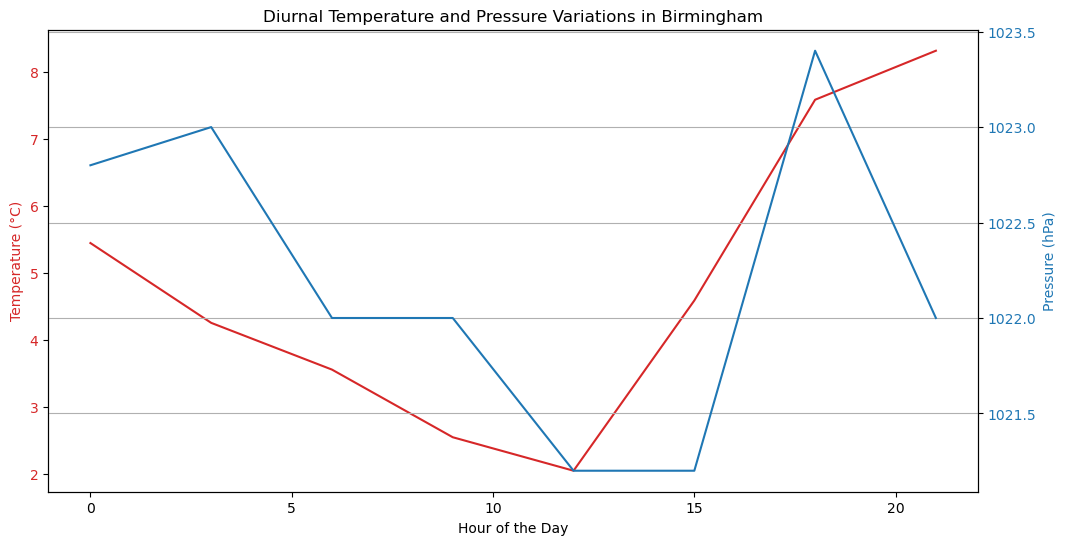

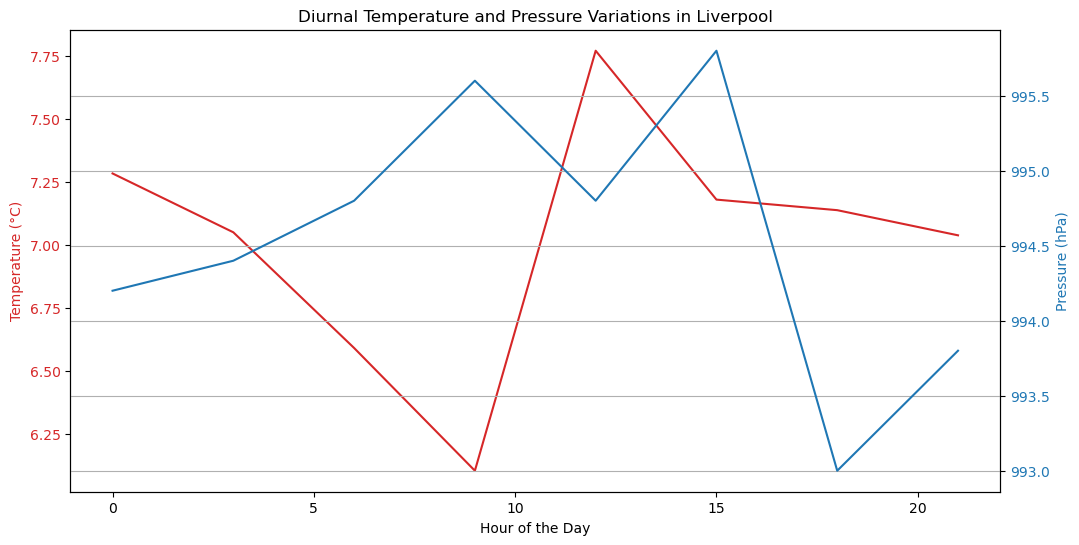

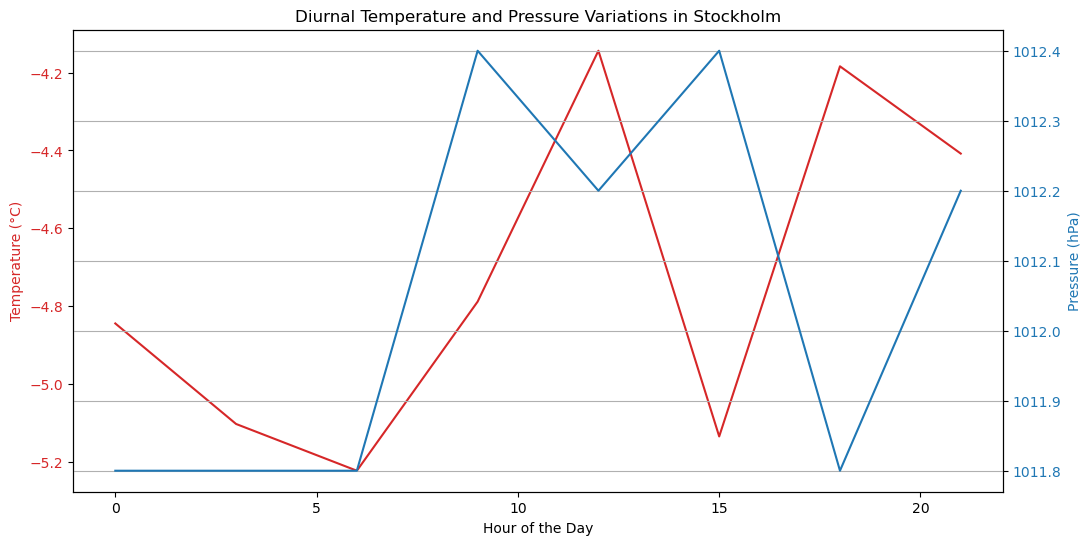

In [32]:
#Subpart1: Diurnal Temperature and Pressure Variations
#Extracting hour from datetime for diurnal analysis
data['hour'] = data['datetime'].dt.hour

# Selecting random cities for a detailed analysis
selected_cities = ['Birmingham', 'Liverpool', 'Stockholm']  

#Diurnal Temperature and Pressure Variations
for city in selected_cities:
    city_data = data[data['city_name'] == city]
    
    # Creating a pivot table for temperature and pressure by hour
    temp_pressure_hourly = city_data.pivot_table(index='hour', values=['temp', 'pressure'], aggfunc='mean')
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Temperature (°C)', color='tab:red')
    ax1.plot(temp_pressure_hourly.index, temp_pressure_hourly['temp'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Pressure (hPa)', color='tab:blue')
    ax2.plot(temp_pressure_hourly.index, temp_pressure_hourly['pressure'], color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Diurnal Temperature and Pressure Variations in {city}')
    plt.grid(True)
    plt.show()


In Birmingham:
From midnight to early morning, the temperature goes down a little, stays pretty stable during the day, and then rises sharply in the evening.
The atmospheric pressure slowly drops from midnight to noon and then slowly rises again in the evening.

In Liverpool:
The temperature drops sharply in the early morning, then rises until noon, drops a little in the afternoon, and then falls again in the evening.
Pressure changes significantly, with many peaks and valleys during the day.

In Stockholm: 
From early morning to around noon, the temperature goes up a lot. In the afternoon, it goes down a lot, and then it stays the same until the evening.
On the other hand between early morning and late afternoon, the pressure slowly drops, but then it rises sharply in the evening.

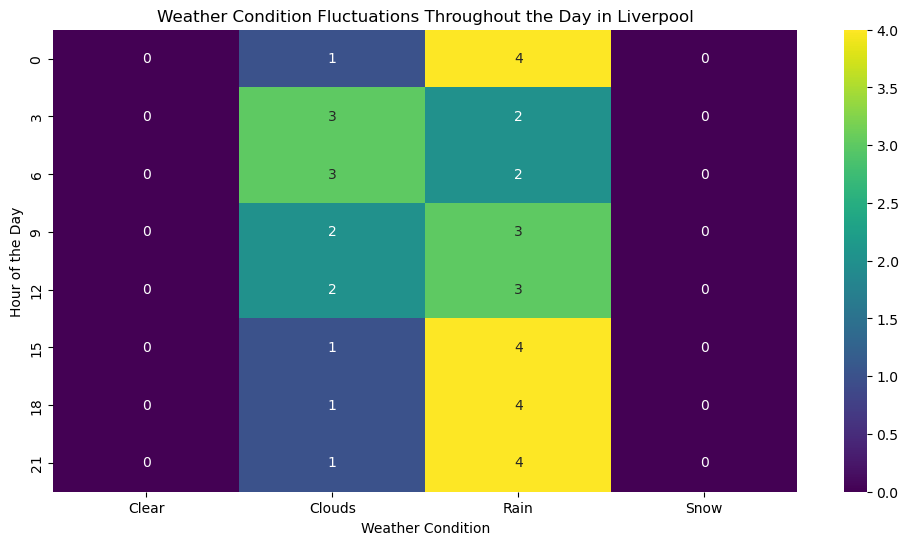

In [33]:
#Subpart2: Weather Condition Fluctuations
# Grouping data by city, hour, and weather condition, then counting occurrences
weather_condition_hourly = data.groupby(['city_name', 'hour', 'weather_main']).size().unstack().fillna(0)

# Plotting weather condition fluctuations for a selected city
selected_city = 'Liverpool'  # Replace with an actual city name from your dataset
city_weather_fluctuation = weather_condition_hourly.loc[selected_city]

plt.figure(figsize=(12, 6))
sns.heatmap(city_weather_fluctuation, annot=True, cmap='viridis')
plt.title(f'Weather Condition Fluctuations Throughout the Day in {selected_city}')
plt.xlabel('Weather Condition')
plt.ylabel('Hour of the Day')
plt.show()


The above heatmap shows there is no clear weather at all during the day. Starting early in the morning around 3a.m., the weather is cloudy, and it stays cloudy with different patterns all day. The rain seems to happen more often, starting in the late morning or early afternoon around 12 noon and continuing most often in the late afternoon and evening from 3p.m. to 9p.m. At noon, there is no snow to be seen.

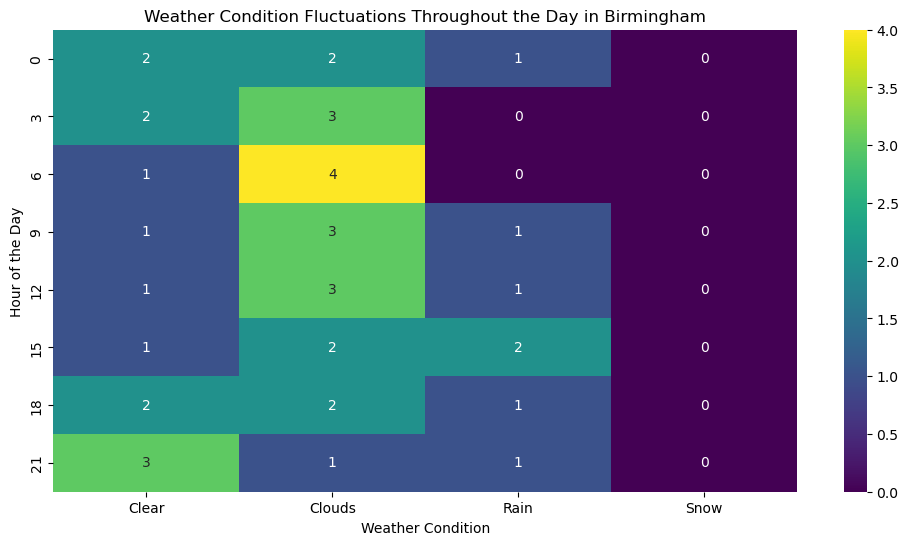

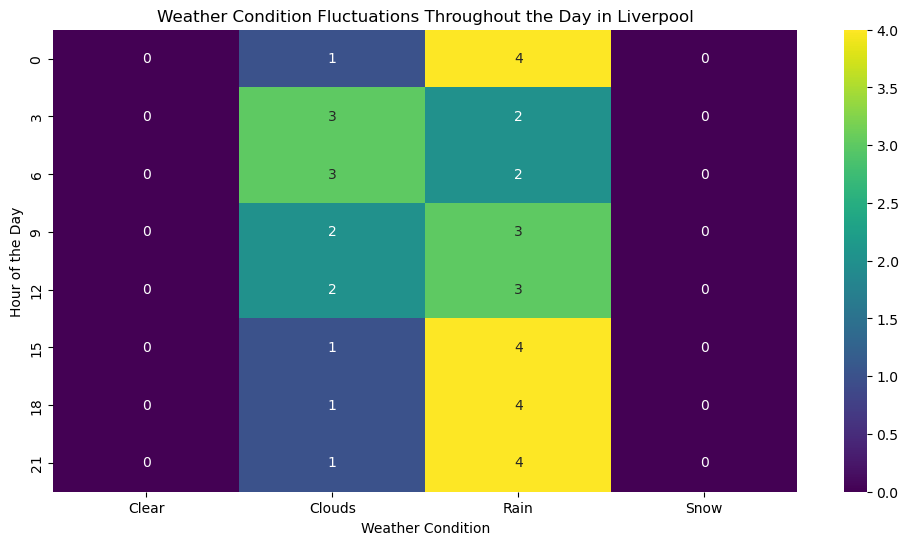

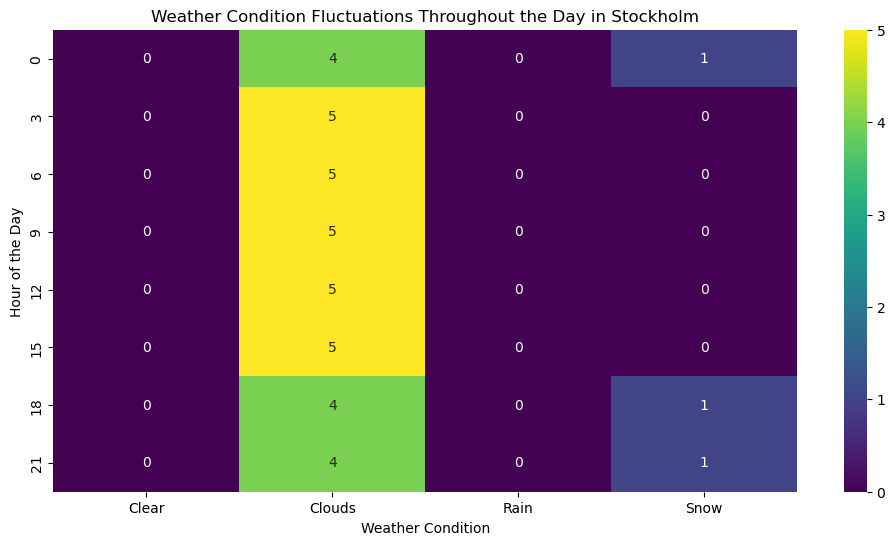

In [34]:
#Subpart3: Comparative City Analysis
'''
These heatmap series will help us compare the patterns of different weather conditions at different times in many 
places by showing different patterns of weather during the day.
'''

# Plotting weather condition fluctuations for multiple cities
for city in selected_cities:  
    city_weather_fluctuation = weather_condition_hourly.loc[city]

    plt.figure(figsize=(12, 6))
    sns.heatmap(city_weather_fluctuation, annot=True, cmap='viridis')
    plt.title(f'Weather Condition Fluctuations Throughout the Day in {city}')
    plt.xlabel('Weather Condition')
    plt.ylabel('Hour of the Day')
    plt.show()
    




Birmingham:
1. Clouds dominate the early morning: Around 6 a.m., there is a noticeable rise in clouds, which could affect traffic and 
visibility during morning rush hour.

2. Nights are clear: The nights are usually clear, especially around 9 p.m., which could be good for outdoor activities
and could change how people in the city enjoy the weather.

3. It rains with varying showers, with some coming early in the morning and late in the afternoon. The uncertain pattern 
of the rain can make it harder to plan for short-term events or services in cities that take place outside.

Liverpool:
1. Cloud Coverage: During the day, clouds are the most common weather condition. They appear more often after midnight and
   stay the same until the early hours of the morning.

2. Rainfall Patterns:It rains most often in the afternoon and evening, between 3 and 6 p.m. There may be a trend for it to 
rain later in the day, which could affect normal travel and outdoor activities.

3. Lack of Clear Skies: There are no views of a clear sky, which means that Liverpool has a lot of clouds and rain, with only
   a few sunny moments during the day.
   
   
For the city of Stockholm:
1. Cloudy Weather: Everything is cloudy in Stockholm during the day; there is never a clear sky to be seen.The pattern of
   clouds points show a cloudy weather.
   
2. Rainy and Snowy conditions:  Rain and snow do happen sometimes, but not as much as cloudy weather. It snows early 
   in the morning and late at night, while it rains at lunchtime and late at night.
   
3. Impact on Daily Life: Clouds with rare rain or snow can change many parts of daily life in Stockholm, from the need
   for regular heating inside to possible problems with transportation and activities outside.
   

For all the cities: These heatmaps can help urban planners and residents guess what the weather will be like during the day.
This could help them plan daily activities, commutes, or city services that depend on the weather, like street cleaning and
repair.



### Learnings from the analysis
Working for this coursework, I learned about new methods of data extraction. Working with API's and actually extracting a dataset out of it was a fascinating task as it was almost a habit to look for datasets on Kaggle and working with them. I learned how different platforms have different policies to launch applications in order to extract data from particular API's.
Learning about different outlier patterns and their treatments during the modules and implementing them practically also helped me get better at coding for data science in python. Exploring libbraries like Numpy, pandas, Matplotlib, seaborn along with requests for putting a request to the API was an integral part of the task. The coursework helped improve my overall data science skills.









### Future Scope
While exploring different API platforms, I came accross the X developer account, formerly known as Twitter developer account. The access is granted after X makes sure that a human is trying to retrieve access. The waiting period ranges from 2-3weeks, but users get access to tweets and can analyse sentiments. Working on a Sentiment Analysis project, analysing sentiments on misleading nature and threats and misuse of artificial intelligence.
